<a href="https://colab.research.google.com/github/mehrshad-sdtn/BSc-Thesis-Project/blob/master/notebooks/schizophrenia_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**This is the final test of the system on out of distribution data**

In [6]:
import os
import cv2
import glob
import math
import random
import pathlib
import numpy as np
import tensorflow as tf
from keras import layers
from os.path import join
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from scipy.fft import fftshift

In [3]:
os.chdir('/content/drive/MyDrive/BSc_Project/')

In [4]:
base_dir = os.getcwd()
print(f'current directory: {base_dir}')

dataset_dir = os.path.join(base_dir, 'datasets')
print(f'datasets directory: {dataset_dir}')

current directory: /content/drive/MyDrive/BSc_Project
datasets directory: /content/drive/MyDrive/BSc_Project/datasets


the recording is 60 seconds long and has total 7680 values
no. subjects = norm: 2, sch:3
shapes:  {'sch': (3, 16, (7680,)), 'norm': (2, 16, (7680,))}

spectrogram data shapes:  {'sch': (3, 12, (10240,)), 'norm': (2, 12, (10240,))}


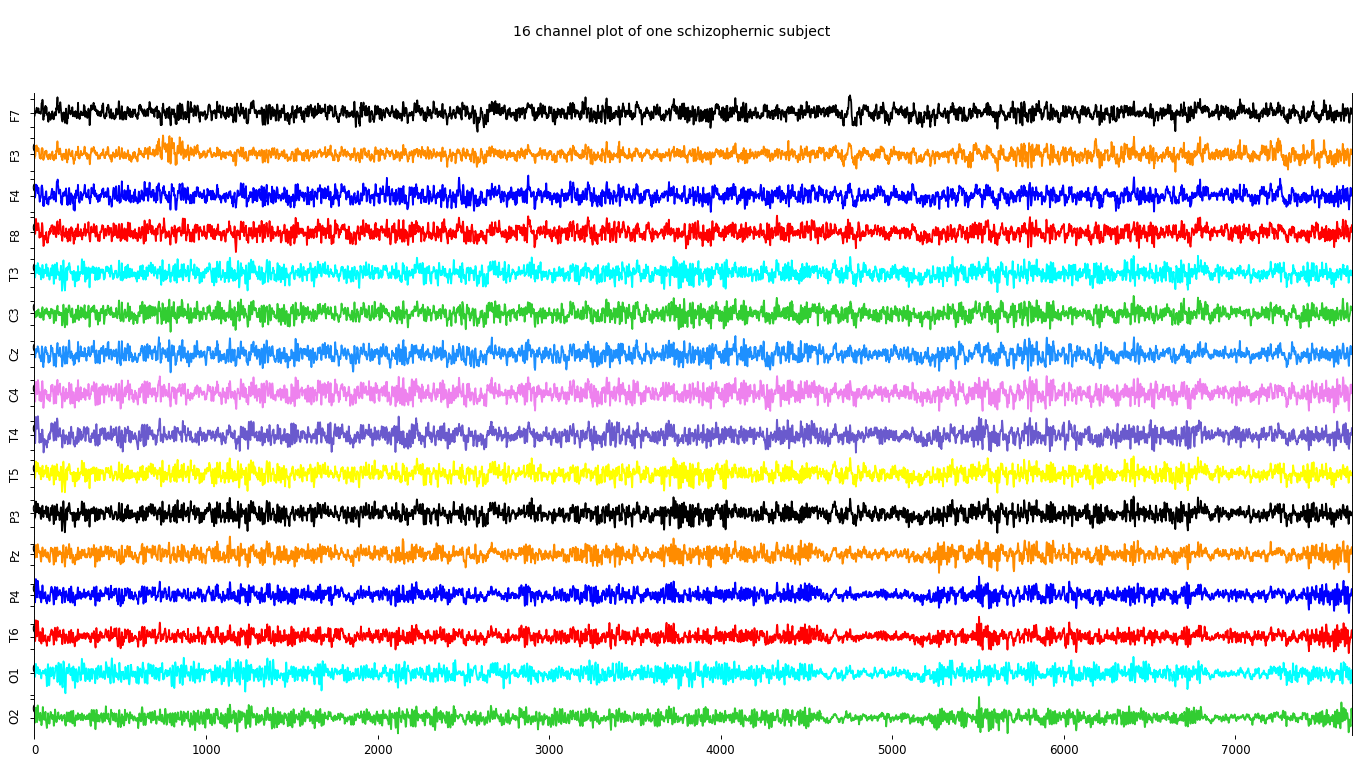

generated:  sub0-seg0
generated:  sub0-seg1
generated:  sub0-seg2
generated:  sub0-seg3
generated:  sub0-seg4
generated:  sub0-seg5
generated:  sub0-seg6
generated:  sub0-seg7
generated:  sub0-seg8
generated:  sub0-seg9
generated:  sub0-seg10
generated:  sub0-seg11
generated:  sub1-seg0
generated:  sub1-seg1
generated:  sub1-seg2
generated:  sub1-seg3
generated:  sub1-seg4
generated:  sub1-seg5
generated:  sub1-seg6
generated:  sub1-seg7
generated:  sub1-seg8
generated:  sub1-seg9
generated:  sub1-seg10
generated:  sub1-seg11
generated:  sub2-seg0
generated:  sub2-seg1
generated:  sub2-seg2
generated:  sub2-seg3
generated:  sub2-seg4
generated:  sub2-seg5
generated:  sub2-seg6
generated:  sub2-seg7
generated:  sub2-seg8
generated:  sub2-seg9
generated:  sub2-seg10
generated:  sub2-seg11
generated:  sub0-seg0
generated:  sub0-seg1
generated:  sub0-seg2
generated:  sub0-seg3
generated:  sub0-seg4
generated:  sub0-seg5
generated:  sub0-seg6
generated:  sub0-seg7
generated:  sub0-seg8
gene

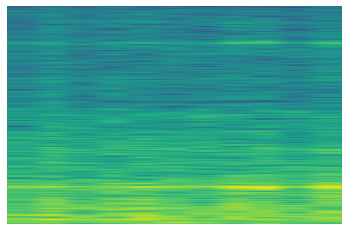

In [21]:
recording_len = 7680
freq = 128
total_time = recording_len // freq

cwd = os.getcwd()

def read_A_dataset(path, case_str):
  case_path = os.path.join(path, case_str)
  subjects_list = []
  for filename in os.listdir(case_path):
    with open(os.path.join(case_path, filename), 'r') as f:
      lines = f.readlines()
      subjects_list.append(lines)
  return subjects_list

# -----------------------------------------
def convert_to_numbers(sub_list):
  new_list = []
  for sub in sub_list:
    new_list.append([float(value) for value in sub])
  return new_list

# -----------------------------------------
def list_segments(lst, segments=16):
  arr = np.array(lst)
  return np.array_split(np.array(arr), segments)


# --------------------------------------------
def divide_to_channels(subjects_list, segments=16):
  return [list_segments(subject, segments) for subject in subjects_list]


# ----------------------------------------------
def log_data_shapes(sch, norm):
  return {
 'sch': (len(sch), len(sch[0]), sch[0][0].shape), 
 'norm': (len(norm), len(norm[0]), norm[0][0].shape)}

# --------------------------------------------------
def divide_time_segments(subject_list, time_window=5):
  n_segments = total_time // time_window
  return [np.split(channel, n_segments) for channel in subject_list]


# -----------------------------------------------
def create_spectrogram_data(subject_list):
  new_subject_list = []
  for subject in subject_list:
    specs = []
    segment_channels = divide_time_segments(subject)
    array_of_arrays = np.array([np.array(channel) for channel in segment_channels])
    for i in range(0, array_of_arrays.shape[1]):
      spec_data = np.squeeze(array_of_arrays[:, i, :].reshape((1, -1)))
      specs.append(spec_data)
    new_subject_list.append(specs)
  return new_subject_list


###############################################################################

colors = ['black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow', 
          'black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow']

channels_16 = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 
               'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

def plot_signals(data, _title, subject_index=0, n_channels=16):
  fig = plt.figure(figsize=(20, 10), dpi=85)
  gs = gridspec.GridSpec(n_channels, 1) 

  for i in range(0, n_channels):
    ax = plt.subplot(gs[i])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    line, = ax.plot(data[subject_index][i], color=colors[i])
    ax.set_yticklabels([])
    ax.set_ylabel(f'{channels_16[i]}')
    plt.xlim([0, recording_len])

  # remove vertical gap between subplots
  plt.suptitle(_title)
  plt.subplots_adjust(hspace=.0)
  plt.show()



def create_spectrogram(data, fs, impath= '', save=False):
  plt.specgram(data, Fs=fs, NFFT=1024)
  if save:
    plt.axis('off')
    plt.savefig(impath, dpi=300, pad_inches=0.0, transparent=True, bbox_inches='tight')
  else: plt.show()



def generate_images_for_subject(path, subject_data, sub_index):
  for i, segment in enumerate(subject_data):
    filename = f'sub{sub_index}-seg{i}'
    print('generated: ', filename)
    create_spectrogram(segment, fs=freq, impath=os.path.join(path, filename), save=True)



def generate_images(data, path, start=0):
  loc = join(cwd, path) 
  if not os.path.exists(loc):
    os.mkdir(loc)
  for i in range(start, len(data)):
    generate_images_for_subject(loc, data[i], i)


#################################| main |#####################################

print(f'the recording is {total_time} seconds long and has total {recording_len} values')


norm_raw_data = convert_to_numbers(read_A_dataset(os.path.join(dataset_dir, 'reserved_A'), 'norm'))
sch_raw_data = convert_to_numbers(read_A_dataset(os.path.join(dataset_dir, 'reserved_A'), 'sch'))
print(f'no. subjects = norm: {len(norm_raw_data)}, sch:{len(sch_raw_data)}')


sch_channels = divide_to_channels(sch_raw_data)
norm_channels = divide_to_channels(norm_raw_data)

print('shapes: ', log_data_shapes(sch_channels, norm_channels))

norm_data = norm_channels
sch_data = sch_channels

norm_specgram_data = create_spectrogram_data(norm_data)
sch_specgram_data = create_spectrogram_data(sch_data)

print('\nspectrogram data shapes: ',log_data_shapes(sch_specgram_data, norm_specgram_data))


plot_signals(sch_data, "\n16 channel plot of one schizophernic subject", 1)

images_path_a = os.path.join('out', 'A_reserved')

generate_images(sch_specgram_data, os.path.join(images_path_a, 'sch'), start=0)
generate_images(norm_specgram_data, os.path.join(images_path_a, 'norm'), start=0)

###**Detection**

In [36]:
print(base_dir)
data_dir = os.path.join(base_dir,'out')
a_dataset = pathlib.Path(os.path.join(data_dir, 'A_reserved'))
models_path = os.path.join(base_dir, 'models')

img_height = 224
img_width = 224

def load_image(filepath, dims):
   image = cv2.cvtColor(
      cv2.imread(filepath), cv2.COLOR_BGR2RGB)
   image = cv2.resize(image, dims)
   image = image.astype('float32') / 255.0
   return image


def image_arrays_from_directory(directory):
  arrays = []
  counter = 0
  for i, cat in enumerate(os.listdir(directory)):
    path = os.path.join(directory, cat)
    for image in os.listdir(path):
      counter += 1
      image = load_image(os.path.join(path, image), dims=(img_height, img_width))
      arrays.append((image, 1 - i))
  print(f"{counter} images were read")
  return arrays



def seperate_lebale(paired_data):
  X = np.array([data for data, label in paired_data])
  y = np.array([label for data, label in paired_data])
  return X, y

test_images = image_arrays_from_directory(a_dataset)
X, y = seperate_lebale(test_images)

print(X.shape, y.shape)


model = keras.models.load_model(os.path.join(models_path, 'simple_model_final.h5')) 

loss, acc = model.evaluate(X, y)
print(f"Test Accuracy: {round(acc * 100, 2)}%")

/content/drive/MyDrive/BSc_Project
60 images were read
(60, 224, 224, 3) (60,)
2/2 [==============================] - 3s 1s/step - loss: 3.1717 - accuracy: 0.8167
Test Accuracy: 81.67%
